**Purpose of the notebook**: in this notebook we have a look at 
results of convex optimization on denoised cov matrix.

In [104]:
import numpy as np
import pandas as pd
import quantstats as qs
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from pypfopt.risk_models import sample_cov
from pypfopt.expected_returns import mean_historical_return

from robustcov.utils import init_mu_cov
from robustcov.runner import PortfolioCreater
from robustcov.optimizers import ConvexOptimizer
from robustcov.optimizers import NCOOptimizer
import statsmodels.api as sm

qs.extend_pandas()


In [105]:
df = pd.read_csv(Path('..') / 'data' / 'indices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')


# convert price history to expected returns and covariance matrix
mu = mean_historical_return(df).values
cov = sample_cov(df).values


In [106]:
df = df[df.index > '2014-06-01']

In [107]:
names = df.columns.tolist() 
countries = np.array([i.split(':')[0] for i in names])
unique_countries, counts = np.unique(countries, return_counts=True)

df['sample'] = np.where(df.index < '2020-06-01', 'train', 'test')

In [108]:
def calc_stats(returns, weights, country, sample):
    weighted_returns = returns.mul(weights.T.mean(axis=1).values, axis=1)
    portfolio_returns = weighted_returns.sum(axis=1)

    return {
        'sample': sample,
        'country': country,
        'sharpe': portfolio_returns.sharpe(),
        'cumreturn': (1 + portfolio_returns).prod(),
        'win_rate': qs.stats.win_rate(portfolio_returns),
        'avg_win': qs.stats.avg_win(portfolio_returns),
        'consecutive_wins': qs.stats.consecutive_wins(portfolio_returns),
        'consecutive_loss': qs.stats.consecutive_losses(portfolio_returns),
        'max_drawdown': qs.stats.max_drawdown(portfolio_returns),
        'expected_return': qs.stats.expected_return(portfolio_returns),
        '1st_percentile_loss': qs.stats.outlier_loss_ratio(portfolio_returns),
        '99st_percentile_win': qs.stats.outlier_win_ratio(portfolio_returns),
        'profit_factor': qs.stats.profit_factor(portfolio_returns)
    }, portfolio_returns


In [109]:


train = df[df['sample'] == 'train']
test = df[df['sample'] == 'test']
train.pop('sample')
test.pop('sample')

statistics = []
portf_train_returns = {}
portf_test_returns = {}

for n, country in enumerate(unique_countries):

    print(f'{n}/{len(unique_countries)}', end='\r')
    country_mask = countries == country
    stocks = train.loc[:, country_mask]
    buy_and_hold = stocks.pct_change().mean(axis=1)

    mu = mean_historical_return(stocks).values
    cov = sample_cov(stocks).values

    if len(mu) < 4:
        continue

    optimizers = [
        ConvexOptimizer()
    ]

    estimator = PortfolioCreater(
        min_var_portf=False,
        optimizers=optimizers,
        print_every=False,
        bandwidth=1,
        trials=10
    )

    results = estimator.estimate(mu, cov)
    weights = pd.DataFrame(results).T

    train_returns = train.loc[:, country_mask].pct_change()
    test_returns = test.loc[:, country_mask].pct_change()

    train_stats, train_returns = calc_stats(train_returns, weights,
                                            country, 'train')
    test_stats, test_returns = calc_stats(test_returns, weights,
                                          country, 'test')

    statistics.append(train_stats)
    statistics.append(test_stats)
    
    portf_train_returns.update({country: train_returns})
    portf_test_returns.update({country: test_returns})


# Strategies

### Sharpe-ratio based selection
Lets derive weights for assets from training set and apply them for testing 
period of a year. Below are characteristics of such an optimization.

In [28]:
stats = pd.DataFrame(statistics)
train = stats[stats['sample'] == 'train'].sort_values('sharpe', ascending=False)
train.head()

,sample,country,sharpe,cumreturn,win_rate,avg_win,consecutive_wins,consecutive_loss,max_drawdown,expected_return,1st_percentile_loss,99st_percentile_win,profit_factor
42,train,Mauritius,3.517573,3.612217,0.592266,0.002799,17,10,-0.052536,0.000821,3.942976,5.842003,2.128485
70,train,United states,3.256826,1.403613,0.592711,0.000891,10,7,-0.012362,0.000217,2.995427,3.079315,1.700073
2,train,Australia,2.947671,1.472789,0.585678,0.001123,9,6,-0.024888,0.000247,2.968762,3.164601,1.607291
8,train,Canada,2.765440,1.275439,0.576087,0.000745,14,10,-0.011487,0.000155,3.188503,3.044205,1.570394
46,train,Morocco,2.330369,7.407637,0.565568,0.007693,9,8,-0.113393,0.001280,2.990888,3.278686,1.469464


In [29]:
test = stats[stats['sample'] == 'test']

test[test['country']\
    .isin(['Sweden', 'Mauritius', 'United states', 'Ireland', 'Canada'])]\
    .sort_values('sharpe', ascending=False)


,sample,country,sharpe,cumreturn,win_rate,avg_win,consecutive_wins,consecutive_loss,max_drawdown,expected_return,1st_percentile_loss,99st_percentile_win,profit_factor
71,test,United states,1.744407,1.039801,0.586207,0.001017,13,5,-0.015328,0.000149,3.507045,3.066420,1.337651
35,test,Ireland,1.220298,1.045249,0.544061,0.001764,8,8,-0.043085,0.000169,2.519038,2.958600,1.218372
43,test,Mauritius,0.946609,1.075269,0.485944,0.003648,9,8,-0.091102,0.000277,5.015381,4.001775,1.206789
9,test,Canada,-0.231478,0.996067,0.524904,0.000726,5,5,-0.017694,-0.000015,2.899135,2.889153,0.963097
63,test,Sweden,-2.073512,0.935430,0.440945,0.001460,6,10,-0.071516,-0.000255,3.178482,3.609935,0.711662


In [30]:
def plot_cum_returns(train, test, country):

    plt.suptitle('Cumulated returns IN and OUT of sample')
    f, ax = plt.subplots(figsize=(16, 5), ncols=2)

    ax[0].set_title('Cumulated returns in-sample')
    ax[1].set_title('Cumulated returns out-of-sample')
    
    (1 + train[country]).cumprod().plot(ax=ax[0])
    (1 + test[country]).cumprod().plot(ax=ax[1])


portf_train = pd.DataFrame(portf_train_returns)
portf_test = pd.DataFrame(portf_test_returns)

<Figure size 1000x600 with 0 Axes>

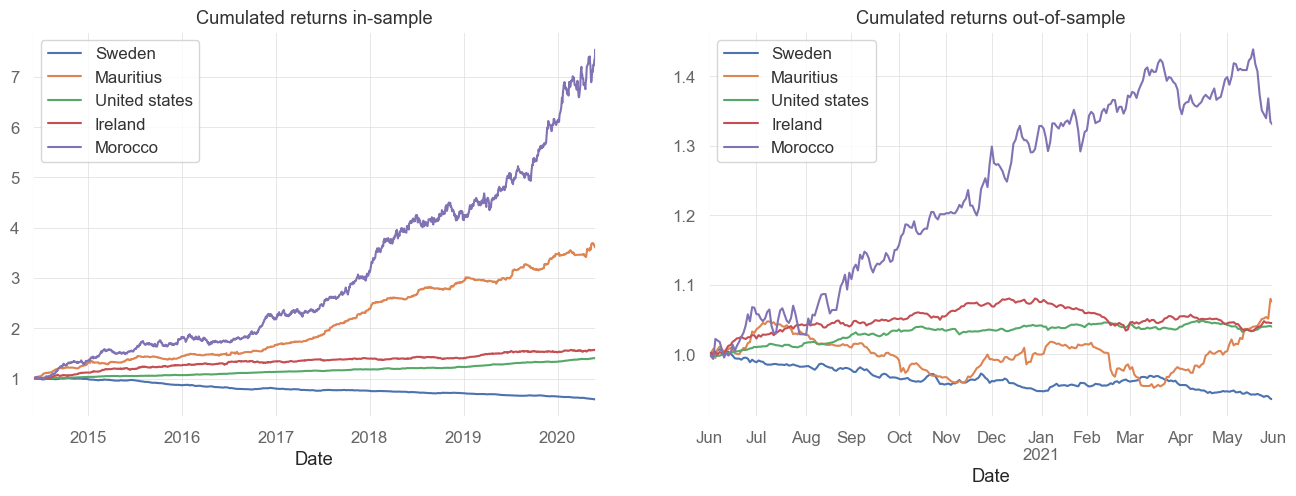

In [31]:
plot_cum_returns(portf_train, portf_test, ['Sweden', 'Mauritius', 'United states', 'Ireland', 'Morocco'])

### Benchmark comparison

We will consider simple buy and hold portfel as benchmark

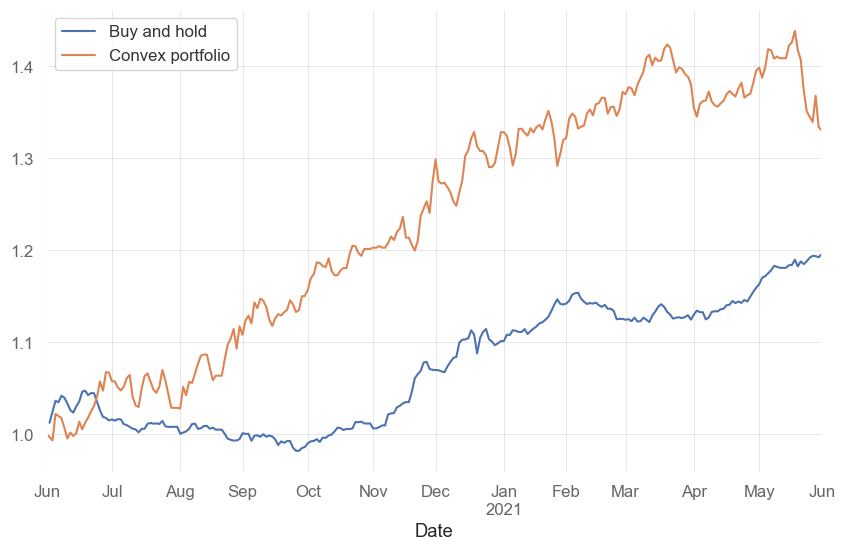

In [43]:
df_test = df[df['sample'] == 'test']


(1 + df_test.loc[:, df_test.columns.str.contains('Morocco')]
    .pct_change()
    .mean(axis=1))\
    .cumprod()\
    .plot(label='Buy and hold')

(1 + portf_test['Morocco'])\
    .cumprod()\
    .plot(label='Convex portfolio')
    
plt.legend()


### Lets measure alpha

We will use CAPM approach to measure alpha. Basically what we estimate is 
the following:

$$
R_i = \alpha + \beta R_m + \varepsilon_i
$$
where $i$ is for each country cluster, $R_i$ - returns of optimized portfolio
and $R_m$ are returns of buy and hold portfolio. We can interpret $\alpha$ as
excess returns over market return and the goal is to identify countries with 
significantly positive $\alpha$.

In [82]:
results = []

for country in portf_test.columns:
    test_country = df_test.loc[:, df_test.columns.str.contains(country)]
    test_country = test_country.pct_change().fillna(0)
    buy_and_hold = test_country.mean(axis=1)

    model = sm.OLS(portf_test['Morocco'], sm.add_constant(buy_and_hold))
    summ = model.fit()

    params = summ.params.copy().rename({'const': 'alpha', 0: 'beta'})
    pvalues = summ.pvalues.copy().rename({'const': 'alpha', 0: 'beta'})

    results.append(
        {
            'country': country,
            'alpha': params['alpha'],
            'beta': params['beta'],
            'alpha_p': pvalues['alpha'],
            'beta_p': pvalues['beta']
        }
    )


In [93]:
results = pd.DataFrame(results)

We can now have a look at countries with strongly positive alpha:

In [94]:
results[results['alpha_p'] < 0.05]

,country,alpha,beta,alpha_p,beta_p
0,Argentina,0.001138,-0.017446,0.044939,0.535611
4,Canada,0.001142,-0.011494,0.046925,0.906166
5,Chile,0.001129,0.002947,0.047863,0.952943
6,China,0.001170,-0.047933,0.039769,0.393608
7,Czech republic,0.001129,-0.385587,0.046532,0.348952
9,Euro zone,0.001149,-0.069106,0.043451,0.657274
13,Hong kong,0.001126,0.007518,0.047946,0.896618
16,Indonesia,0.001175,-0.037602,0.039291,0.414761
18,Israel,0.001143,-0.020097,0.044581,0.754683
21,Mauritius,0.001151,-0.111161,0.043075,0.589798


And pretty interesting, that no significant beta across clusters is found,
despite the fact, t

In [95]:
results[results['beta_p'] < 0.05]

,country,alpha,beta,alpha_p,beta_p
